C:\Users\rosan\tensorflow_env\Lib\site-packages\sklearn\ensemble\_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


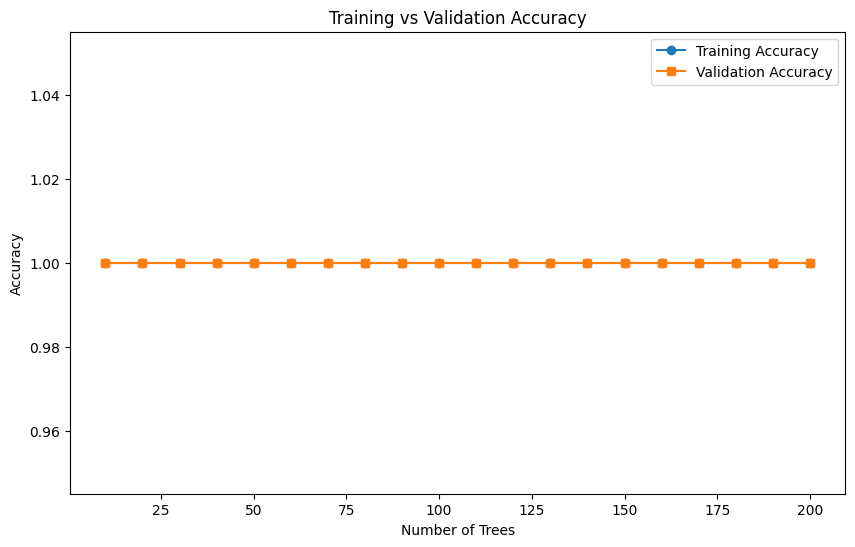


Model Performance:
Accuracy: 1.0
F1 Score: 1.0
MCC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        29
           3       1.00      1.00      1.00        61
           4       1.00      1.00      1.00        29

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161



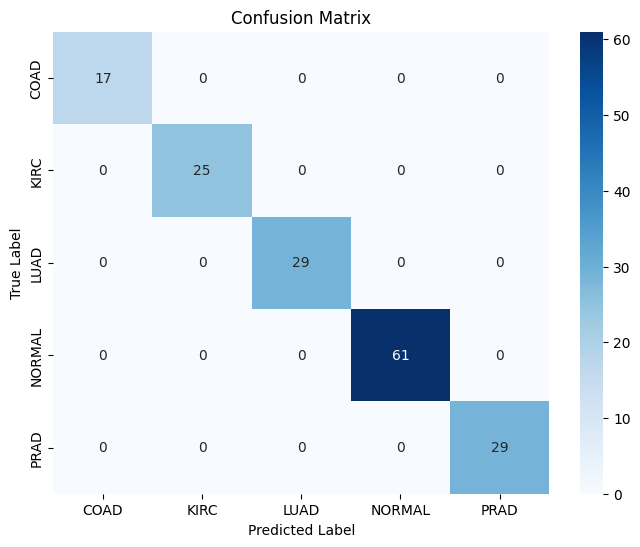

Enter the file path of the patient data:  Test_set_3.csv



Prediction Results:
sample_34: Diagnosed with PRAD


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, matthews_corrcoef, confusion_matrix

# Load datasets
data = pd.read_csv("data.csv")  # Gene expression data
labels = pd.read_csv("labels.csv")  # Class labels (cancer type or healthy)

# Merge data and labels
df = pd.concat([labels, data], axis=1)

# Drop unnecessary columns
df.drop(columns=['Unnamed: 0', 'Unique_ID'], axis=1, errors='ignore', inplace=True)

# Encode cancer type labels
label_encoder = LabelEncoder()
df['Class'] = label_encoder.fit_transform(df['Class'])
class_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Features and Target
X = df.drop(columns=['Class'], errors='ignore')
y = df['Class']

# Ensure only numeric data
X = X.select_dtypes(include=[np.number])

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Training vs Validation Accuracy
oob_error = []
train_accuracy = []
test_accuracy = []

for n in range(10, 201, 10):
    model = RandomForestClassifier(n_estimators=n, random_state=42, oob_score=True, n_jobs=-1)
    model.fit(X_train, y_train)
    train_accuracy.append(model.score(X_train, y_train))
    test_accuracy.append(model.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(range(10, 201, 10), train_accuracy, label='Training Accuracy', marker='o')
plt.plot(range(10, 201, 10), test_accuracy, label='Validation Accuracy', marker='s')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluate Model
print("\nModel Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("MCC:", matthews_corrcoef(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

def predict_from_file(file_path):
    # Load new patient data
    try:
        patient_data = pd.read_csv(file_path)
    except Exception as e:
        print("\nError loading file:", str(e))
        return
    
    # Ensure feature alignment
    patient_data.set_index('Sample_Name', inplace=True, drop=False)
    patient_data = patient_data[X.columns]  # Keep only relevant features
    
    # Scale data
    patient_scaled = scaler.transform(patient_data)
    
    # Predict
    predictions = rf_model.predict(patient_scaled)
    prediction_proba = rf_model.predict_proba(patient_scaled)
    
    # Display results
    results = []
    for i, sample in enumerate(patient_data.index):
        prediction = predictions[i]
        if prediction == 0:
            risk_percentage = prediction_proba[i][1] * 100
            future_risk = prediction_proba[i][1] * 100  # Estimate future risk based on probability
            result = f"{sample}: Healthy (Cancer Occurrence Risk: {risk_percentage:.2f}%, Future Risk: {future_risk:.2f}%)"
        else:
            cancer_type = list(class_mapping.keys())[list(class_mapping.values()).index(prediction)]
            result = f"{sample}: Diagnosed with {cancer_type}"
        results.append(result)
    
    print("\nPrediction Results:")
    for res in results:
        print(res)

# Example usage
file_path = input("Enter the file path of the patient data: ")
predict_from_file(file_path)

